In [1]:
import os

is_kaggle = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")
is_kaggle = bool(is_kaggle)

is_kaggle

False

In [2]:
if is_kaggle:
    !pip install --no-index --no-deps /kaggle/input/pycocotools/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl

In [3]:
from pathlib import Path
from typing import Text

import base64
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zlib

from pycocotools import _mask as coco_mask
import torch
from torch import nn, Tensor
from torchvision.models import get_model
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import Normalize
from torchvision.transforms.functional import to_tensor
from torchvision.utils import draw_segmentation_masks

In [4]:
if is_kaggle:
    DATA_DIR = Path("/kaggle/input/hubmap-hacking-the-human-vasculature")
    MODEL_DIR = Path("/kaggle/input/hubmap-models")
else:
    DATA_DIR = Path("../data/hubmap")
    MODEL_DIR = Path("../models/cur_best")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained models

## Blood vessel Mask R-CNN detector

In [5]:
def get_maskrcnn(num_classes: int = 2, predictor_hidden_size: int = 256):
    model = maskrcnn_resnet50_fpn(weights=None, weights_backbone=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       predictor_hidden_size,
                                                       num_classes)
    return model

In [6]:
rcnn = get_maskrcnn(num_classes=2)
rcnn.load_state_dict(torch.load(MODEL_DIR / "mask_r-cnn.pth", map_location="cpu"))
rcnn = rcnn.to(DEVICE)
rcnn.eval();

## Glomerulus U-Net segmentation model

In [7]:
class ResNetFeatures(nn.Module):
    def __init__(self, pretrained: bool = True, num_layers: int = 50):
        super().__init__()
        # check argument values
        nl_lst = [18, 34, 50, 101, 152]
        assert num_layers in nl_lst, f"num_layers should be one of {nl_lst}"
        weights = "DEFAULT" if pretrained else None

        # create model
        rn = get_model(f"resnet{num_layers}", weights=weights)
        self.conv1 = rn.conv1
        self.bn1 = rn.bn1
        self.relu = rn.relu
        self.maxpool = rn.maxpool
        self.layer1 = rn.layer1
        self.layer2 = rn.layer2
        self.layer3 = rn.layer3
        self.layer4 = rn.layer4

        # number of trainable layers (between 0 and 5)
        self.n_trainable_layers = 5

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def set_n_trainable_layers(self, n: int):
        assert 0 <= n <= 5
        to_train = ["layer4", "layer3", "layer2", "layer1", "conv1"][:n]
        if n == 5:
            to_train.append("bn1")
        for name, parameter in self.named_parameters():
            in_list = any(name.startswith(layer) for layer in to_train)
            parameter.requires_grad_(in_list)
        self.n_trainable_layers = n


class PSDecoderBlock(nn.Module):
    "Lightweight decoder block with PixelShuffle upsampling"
    def __init__(self, in_channels: int, out_channels: int,
                 skip_connection: bool = True, upscale_factor: int = 2):
        super().__init__()
        self.upsample = nn.PixelShuffle(upscale_factor=upscale_factor)
        conv_channels = in_channels // upscale_factor**2
        if skip_connection:
            conv_channels *= 2
        self.conv_block = nn.Sequential(
            nn.Conv2d(conv_channels, conv_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(conv_channels),
            nn.GELU(),
            nn.Conv2d(conv_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )
        self.skip_connection = skip_connection  # boolean flag

    def forward(self, x: Tensor, skip_con: Tensor | None = None) -> Tensor:
        x = self.upsample(x)
        if skip_con is not None:
            x = torch.cat([x, skip_con], dim=1)
        return self.conv_block(x)


class ResUNet(nn.Module):
    "U-Net with ResNet backbone"
    def __init__(self, pretrained: bool = True, resnet_layers: int = 50,
                 out_channels: int = 1, trainable_backbone_layers: int = 3):
        super().__init__()
        assert resnet_layers >= 50, "ResNet18/34 not supported"
        self.normalize = Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
        self.encoder = ResNetFeatures(pretrained=pretrained,
                                      num_layers=resnet_layers)
        self.set_trainable_backbone_layers(trainable_backbone_layers)
        self.sc_convs = nn.ModuleDict({
            "relu": self._skip_con(64, 64),
            "layer1": self._skip_con(256, 128),
            "layer2": self._skip_con(512, 256),
            "layer3": self._skip_con(1024, 512),
        })
        self.decoder = nn.ModuleList([
            PSDecoderBlock(2048, 1024),
            PSDecoderBlock(1024, 512),
            PSDecoderBlock(512, 256),
            PSDecoderBlock(256, 128),
            PSDecoderBlock(128, 32, skip_connection=False)
        ])
        self.head = nn.Conv2d(32, out_channels, 1, 1)

    def forward(self, x: Tensor) -> Tensor:
        # encode input and collect intermediate feature maps
        x = self.normalize(x)
        skip_connections = [None]
        for name, module in self.encoder.named_children():
            x = module(x)
            if name in self.sc_convs.keys():
                skip_connections.append(self.sc_convs[name](x))
        # decode collected feature maps
        for module in self.decoder:
            sc = skip_connections.pop()
            x = module(x, sc)
        # final transformation
        return self.head(x)

    @staticmethod
    def _skip_con(c_in: int, c_out: int):
        "Skip connection from encoder to decoder"
        if c_in == c_out:
            return nn.Identity()
        return nn.Sequential(
            nn.Conv2d(c_in, c_out, 1, 1, 0),
            nn.GELU()
        )

    @staticmethod
    def _dec_block(c_in: int, c_out: int) -> nn.Module:
        return nn.Sequential(
            nn.PixelShuffle(upscale_factor=2),
            nn.Conv2d(c_in // 4, c_in // 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(c_in // 4),
            nn.GELU(),
            nn.Conv2d(c_in // 4, c_out, 1, 1, 0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.GELU()
        )

    def set_trainable_backbone_layers(self, n: int):
        self.encoder.set_n_trainable_layers(n)

In [8]:
unet = ResUNet(pretrained=False, resnet_layers=50, out_channels=1)
unet.load_state_dict(torch.load(MODEL_DIR / "u-net.pth", map_location="cpu"))
unet = unet.to(DEVICE)
unet.eval();

# Visualise model operation

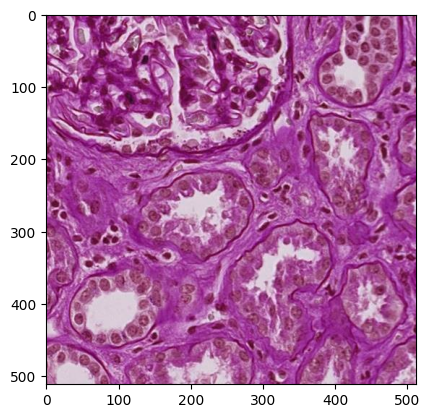

In [9]:
# unannotated image from dataset 3
image_path = DATA_DIR / "train" / f"a2335399a74c.tif"
image = cv2.imread(str(image_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [10]:
def process_glomerulus_mask(mask: Tensor) -> Tensor:
    assert mask.ndim == 2 and mask.dtype == torch.uint8
    mask = mask.detach().cpu().numpy()
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=5)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=20)
    return torch.tensor(mask)

In [11]:
@torch.no_grad()
def detect_blood_vessels(image, det_model, seg_model, overlap_thresh=0.5):
    image_t = to_tensor(image).unsqueeze(0).to(DEVICE)
    glom_mask = torch.sigmoid(seg_model(image_t))[0, 0].cpu()
    glom_mask = glom_mask.round().clip(0, 1).to(torch.uint8)
    glom_mask = process_glomerulus_mask(glom_mask).to(torch.bool)

    # get blood vessel detections
    detections = det_model(image_t)[0]
    masks = detections["masks"].cpu().squeeze(1).round().to(torch.bool)

    # find detections ovelapping with glomerulus mask
    intersections = torch.logical_and(glom_mask, masks)
    overlaps = intersections.flatten(1).sum(1) / masks.flatten(1).sum(1)
    keep = overlaps < overlap_thresh

    out = {}
    out["image"] = torch.tensor(image.transpose(2, 0, 1), dtype=torch.uint8)
    out["scores"] = detections["scores"].cpu()
    out["boxes"] = detections["boxes"].cpu()
    out["masks"] = masks
    out["glomerulus"] = glom_mask
    out["keep"] = keep

    return out

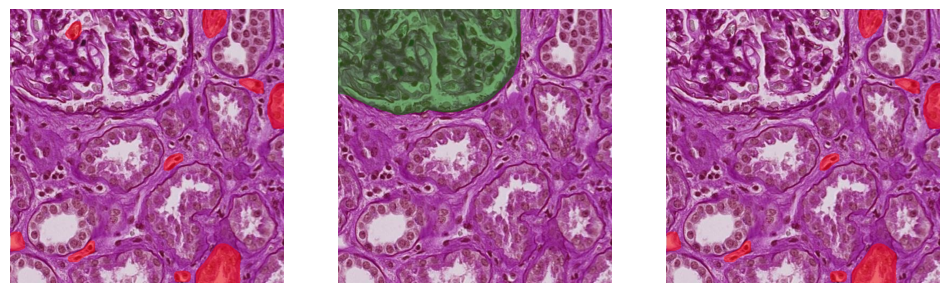

In [12]:
out = detect_blood_vessels(image, rcnn, unet, 0.5)

before = draw_segmentation_masks(
    image=out["image"],
    masks=out["masks"],
    colors=["red"] * len(out["masks"]),
    alpha=0.5
)
glomerulus = draw_segmentation_masks(
    image=out["image"],
    masks=out["glomerulus"],
    colors=["green"],
    alpha=0.5
)
after = draw_segmentation_masks(
    image=out["image"],
    masks=out["masks"][out["keep"]],
    colors=["red"] * (out["masks"].sum()),
    alpha=0.5
)

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches((12, 4))
for ax, img in zip(axes, [before, glomerulus, after]):
    ax.imshow(img.numpy().transpose(1, 2, 0))
    ax.set_axis_off()

# Create submission file

In [13]:
def encode_binary_mask(mask: np.ndarray) -> Text:
    "Converts a binary mask into OID challenge encoding ascii text."
    # check input mask --
    if mask.dtype is not np.dtype("bool"):
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

In [14]:
test_dir = DATA_DIR / "test"

fout = open("submission.csv", "w")
D = ","
fout.write(D.join(["id", "height", "width", "prediction_string"]) + "\n")

for f in test_dir.iterdir():
    image = cv2.imread(str(f))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fout.write(
        D.join([f.stem, str(image.shape[0]), str(image.shape[1])])
        + D
    )

    predictions = detect_blood_vessels(image, rcnn, unet, 0.5)
    keep = predictions["keep"]
    scores = predictions["scores"][keep]
    masks = predictions["masks"][keep]

    for score, mask in zip(scores, masks):
        mask = mask.numpy()
        code = encode_binary_mask(mask).decode("utf-8")
        fout.write(" ".join(["0", str(score.item()), code]) + " ")

    fout.write("\n")

fout.close()